In [91]:
import cv2
# import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
# import matplotlib.pyplot as plt
# from segpy.dataset import Dataset
import logging
from pathlib import Path
from scipy import signal
import toml
from PIL import Image, ImageOps
import datetime 
logger = logging.getLogger(__name__)
import os
from scipy.signal import butter, lfilter, freqz

from image2segy_utils import *

import matplotlib.pyplot as plt
%matplotlib inline
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\rawimages\undone\\'
files=['0047_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-108_crop.png',
#        '00018_1966_SABAH_2D_Repro_1966_Time_Unmigrated_ 1A _crop.png'
#       'test.png',
#        '0128_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ B-129_crop.png'
      ]

In [12]:
def findHorlineIndex(clipped_im,horizontalsize=30):
    h,w=clipped_im.shape
    selim=clipped_im[:int(h/10),:int(w/55)]
    horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
    rows,cols = horizontal.shape
    # horizontalsize = 30
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,2))
    # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
    horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
    selim=horizontal.astype(float)

    # selim[selim<=127.0]=1
    # selim[selim>127.0]=0
    res=selim.sum(axis=1)
    mindx=np.argmin(res)
    checkval=np.mean(res)-2*np.std(res)
    idxs=np.where(res<checkval)[0]
    if len(idxs)>0:
        if mindx==idxs[0]:
            return mindx
        else:
            return idxs[0]
    else:
        return mindx
def getColumnShifts(clipped_im,zerotlineid):
    mp=zerotlineid
    pad=int(clipped_im.shape[0]/30)
    fpad,bpad=pad,pad
    #     print(mp,pad)
    if pad>mp:
        fpad=mp
    resim=clipped_im[mp-fpad:mp+bpad,:]

    horizontal = cv2.adaptiveThreshold(resim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
    rows,cols = horizontal.shape
    horizontalsize=10
    #     print('horizontalsize',horizontalsize)
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
    # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
    horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))

    resim=horizontal.astype(float)
    width=5
    ncols=horizontalsize
    mfilter=np.vstack([np.zeros((width,ncols))-0.5,np.ones((width,ncols)),np.zeros((width,ncols))-0.5])
    opencvOutput = cv2.filter2D(resim, -1, mfilter)
    ffpad=3 if fpad/2 >3 else int(fpad/2 )
    fbpad=3
    midxs=[]
    window=10
    for i in range(window,opencvOutput.shape[1],window):
        start,endx=mp-ffpad,mp+fbpad
        if start<0:
            start=0
        poo=opencvOutput[start:endx,i-window:i]    
    #     print(i)
        idxs=np.argmin(poo,axis=0)
        nowidxs=start+idxs

        # poo=opencvOutput[mp-ffpad:mp+fbpad,i-window:i]    
        # idxs=np.argmin(poo,axis=0)
        # nowidxs=mp-ffpad+idxs
        midxs.extend(list(nowidxs))
        mp=int(np.mean(nowidxs))
    poo=opencvOutput[mp-ffpad:mp+fbpad,i:]    
    idxs=np.argmin(poo,axis=0)
    nowidxs=mp-ffpad+idxs
    midxs.extend(list(nowidxs))
    return np.arange(len(midxs)), np.array(midxs)

In [73]:
for f in files:
    print("'{}':{}'strc':1,'ntrace':3815,'trange':[0,6]{},".format(f[:4],'{','}'))

'0047':{'strc':1,'ntrace':3815,'trange':[0,6]},
'0001':{'strc':1,'ntrace':3815,'trange':[0,6]},


In [92]:

file=files[-1]
key=2
timeranges={'0047':[0,6],'108':[0,6],'109':[0,6],'111':[0,6],'116':[0,6],'117':[0,6],'119':[0,6],'0254':[0,5]}
filekey=file.split('_')[0]

fileproperties={'0047':{'strc':1,'ntrace':3461,'trange':[0,6],'0001':{'strc':1,'ntrace':620,'trange':[0,2.5]},},
}

filekey

'0047'

In [149]:
image = cv2.imread(datafolder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clipped_im=gray#[:1000,:1000]

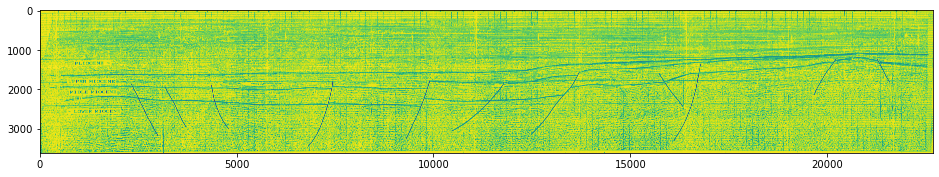

In [150]:
# clipped_im=gray[:1000,:1000]
fig=plt.figure(figsize=(16,4))
plt.imshow(clipped_im)

In [154]:
zerotlineid=findHorlineIndex(clipped_im,horizontalsize=10)

h,w=clipped_im.shape
h,w,zerotlineid

(3614, 22673, 0)

76

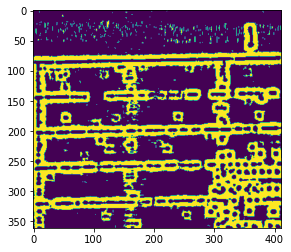

In [155]:


# getColumnShifts(clipped_im,zerotlineid)
horizontalsize=10
h,w=clipped_im.shape
ch,cw=int(h/10),int(w/55)
if ch<200 or cw<200:
    if ch<200:
        ch=200
    if cw<200:
        cw=200
selim=clipped_im[:ch,:cw]
# selim=clipped_im[:int(h/2),:int(w/5)]
horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)

# rows,cols = horizontal.shape
# # horizontalsize = 30
# horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,4))
# # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
# horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
selim=horizontal.astype(float)

fig=plt.figure(figsize=(16,4))
plt.imshow(horizontal)
# selim[selim<=127.0]=1
# selim[selim>127.0]=0
res=selim.sum(axis=1)
mindx=np.argmin(res)
checkval=np.mean(res)-2*np.std(res)
if checkval<0:
    checkval=np.mean(res)
idxs=np.where(res>checkval)[0]
fbreak=np.where(np.diff(idxs)>1)[0]

zerotlineid=np.mean(idxs[:fbreak[0]]).astype(int)
zerotlineid

(98115.66287059119, 23007.157926406537, 144129.97872340426)

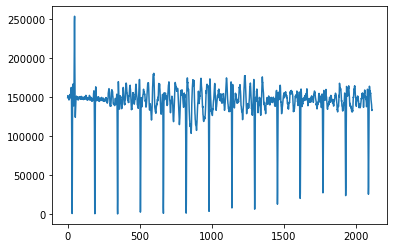

In [83]:
plt.plot(res)
checkval,np.std(res),np.mean(res)

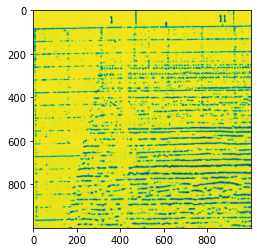

In [64]:
fig=plt.figure(figsize=(16,4))
plt.imshow(clipped_im)

In [167]:
resim.shape,start,endx
pad
np.random.sample(20,30,40)

TypeError: random_sample() takes at most 1 positional argument (3 given)

In [157]:
denom=30
pad=int(clipped_im.shape[0]/denom)
while pad<mp:
    denom-=5
    print(denom,pad,mp)
    pad=int(clipped_im.shape[0]/denom)    
    
pad,mp

(120, 60)

In [162]:
# xvals,indexes=getColumnShifts(clipped_im,zerotlineid)

mp=zerotlineid
denom=30
pad=int(clipped_im.shape[0]/denom)
while pad<mp:
    denom-=5
    print(denom,pad,mp)
    pad=int(clipped_im.shape[0]/denom) 
fpad,bpad=mp,pad

print(mp,fpad)
resim=clipped_im[mp-fpad:mp+bpad,:]

horizontal = cv2.adaptiveThreshold(resim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
rows,cols = horizontal.shape
horizontalsize=10
#     print('horizontalsize',horizontalsize)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
# horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))

resim=horizontal.astype(float)
width=5
ncols=horizontalsize
mfilter=np.vstack([np.zeros((width,ncols))-0.5,np.ones((width,ncols)),np.zeros((width,ncols))-0.5])
opencvOutput = cv2.filter2D(resim, -1, mfilter)
ffpad=3 if fpad/2 >3 else int(fpad/2 )
fbpad=3
midxs=[]
window=60
opencvOutput.shape,mp
for i in range(window,opencvOutput.shape[1],window):
#     print(i)
    try:
        start,endx=mp-ffpad,mp+fbpad
#         print(start,endx)
        if start<0:
            start=0
        poo=opencvOutput[start:endx,i-window:i]    
    #     print(i)
        idxs=np.argmin(poo,axis=0)
        nowidxs=start+idxs

        # poo=opencvOutput[mp-ffpad:mp+fbpad,i-window:i]    
        # idxs=np.argmin(poo,axis=0)
        # nowidxs=mp-ffpad+idxs
        midxs.extend(list(nowidxs))
        mp=int(np.mean(nowidxs))
    except:
        print(i, end='ndone')
poo=opencvOutput[mp-ffpad:mp+fbpad,i:]    
idxs=np.argmin(poo,axis=0)
nowidxs=mp-ffpad+idxs
midxs.extend(list(nowidxs))

76 76


In [138]:
# opencvOutput.shape
# midxs

# midxs

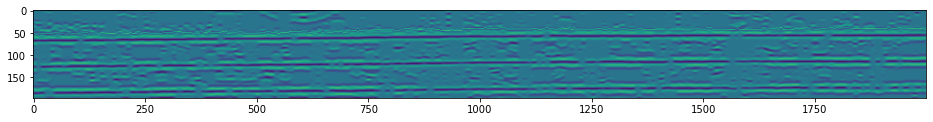

In [164]:
# indexes=[]
# for i,mi in enumerate(midxs):
#     indexes.append(np.array([mi,i]))
#     opencvOutput[mi,i]=20000
# np.array(indexes)
fig=plt.figure(figsize=(16,4))
plt.imshow(opencvOutput[:,2000:4000])

(array([ 1122.,  3008.,  7642., 18212., 38112., 74727., 18480., 11353.,
         5193.,   151.]),
 array([-1.2750000e+04, -1.0200000e+04, -7.6500000e+03, -5.1000000e+03,
        -2.5500000e+03, -1.8189894e-12,  2.5500000e+03,  5.1000000e+03,
         7.6500000e+03,  1.0200000e+04,  1.2750000e+04]),
 <BarContainer object of 10 artists>)

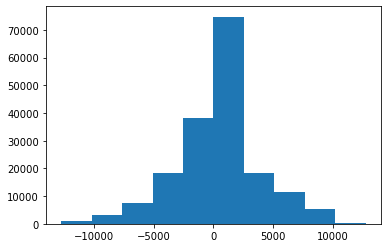

In [133]:
# opencvOutput[np.array(indexes)]
plt.hist(opencvOutput.ravel())

In [63]:

# fig=plt.figure(figsize=(16,4))
# plt.imshow(opencvOutput)
# i=10
mp=zerotlineid
start,endx=mp-ffpad,mp+fbpad
print(start,endx)
# opencvOutput[start:endx,i-window:i] 
opencvOutput[start:endx,:],opencvOutput.shape

75 81


(array([], shape=(0, 1000), dtype=float64), (66, 1000))

In [ ]:
# bestcases={1:1,2:3,3:6}
for file in files:
    filekey=file.split('_')[0]
    ntrace=fileproperties[filekey]['ntrace']
    ntrc=ntrace
    strc=fileproperties[filekey]['strc']
    etrc=strc+ntrc
    stime,etime=np.array(fileproperties[filekey]['trange'])*1000
    strc,etrc,ntrc,stime,etime

    image = cv2.imread(datafolder+file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sgray=gray.sum(axis=1)

    print(file,gray.shape)

    sgray=gray.sum(axis=1)
    cutoff = 30.0
    bestcases={'':6}
    for key in bestcases:
        case=bestcases[key]

    # for case in range(1,7):
        print('Case: ',case)
        crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
        #Horizontal filter calculation to remove horizontal lines
        twt=list(range(len(sgray)))
        lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
        useHorfilter=True
        crude_hor_filter=False
        if useHorfilter:
            if not crude_hor_filter:
                hlfilter=gethorizontalLineFilter(hf_data,gray) #median gap found and kept lo values to nullify horizontal line
                hlfilter[hlfilter<=0.5]=0.5
                print('hlfilter')
            else:
                hlfilter=getHorizontalRawFilter(hf_data) #filter generate with crude way, line gaps are filled with 0.1 values

        mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        #     traces=img2rawtrace(clipped_im,stime,etime,ntrc)
        traces=img2rawtrace(mthresh,stime,etime,ntrc)
        traces=successiveDeduction(traces,ntraces=200)

        # fig=plt.figure(figsize=(18,16))
        # plt.imshow(traces.T)


        # plt.plot(traces[:,int(for50msec)])

        #Operator for smooth trace
        trcno=200
        mtrc=traces[trcno]


        if useHorfilter:
            mtrc=mtrc*hlfilter

        if not useStepOp:
            op=getOperator(mtrc,old=False)
        else:
            op=getOperatorStep(mtrc)


        # Filter or not and make resultant traces as float64 type
        tracet=traces.shape[1]
        actualt=etime
        tracetpermsec=tracet/etime
        for50msec=tracetpermsec*30
        traces[:,:int(for50msec)]=traces[:,:int(for50msec)]*0.1

        if useHorfilter:
            result=(np.array(traces)*hlfilter*1000).astype(np.float64)
        else:
            result=(np.array(traces)*1000).astype(np.float64)

        print(traces.shape,result.shape)
        trange=np.arange(stime,etime+1,2).astype(int)
        proctrcs= getOpProcTraces(result,op,trange)
    #     filttrcs=np.array(proctrcs)
        filttrcs= getLowPassfilteredTraces(proctrcs,cutoff = cutoff )



        inputdict=dict(dstpath=datafolder+file.replace('_crop.png','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
                   mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

        status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2,strc=strc,setimes=[stime,etime])
        if status:    
            print('Done export..',inputdict['dstpath'])
        else:
            print('Export incomplete..')
#         fig=plt.figure(figsize=(16,16))
#     #     plt.imshow(filttrcs.T[:800,-800:])
#         plt.imshow(filttrcs.T)
#         plt.show()